In [1]:
import snsql
from snsql import Privacy
import sqlite3

privacy = Privacy(epsilon=0.1, delta=0.1) #standard: epsilon=1, delta=0.01
meta_path = 'medical.yaml'

conn = sqlite3.connect("medical.db")
reader = snsql.from_connection(conn, privacy=privacy, metadata=meta_path)
cur = conn.cursor()

/Users/lukas/opt/anaconda3/lib/python3.9/site-packages/snsql/sql/private_reader.py:121: UserWarning: Dimension censoring is enabled, with Mechanism.discrete_laplace as the thresholding mechanism. 
This is an unsafe floating point mechanism.  Counts used for censoring will be revealed in any queries that request COUNT DISTINCT(person), 
leading to potential privacy leaks. If your query workload needs to reveal distinct counts of individuals, consider doing the dimension
censoring as a preprocessing step.  See the documentation for more information.
  warnings.warn(


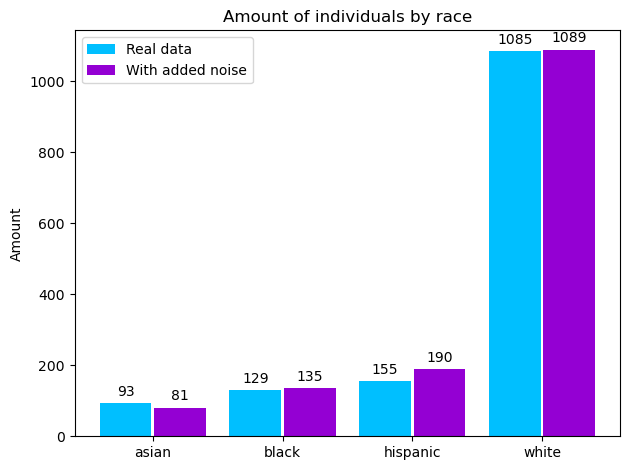

In [2]:
query = 'SELECT race, count(patient) AS amount FROM patients GROUP BY race'

cur.execute(query)
data = cur.fetchall()
noiseData = reader.execute(query)

labels, realCounts = map(list, zip(*data))
_, privateCounts = map(list, zip(*noiseData[1:]))

import matplotlib.pyplot as plt
import numpy as np
x = np.arange(len(labels))
width = 0.4

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2 - 0.01, realCounts, width, label='Real data', color='deepskyblue')
rects2 = ax.bar(x + width/2 + 0.01, privateCounts, width, label='With added noise', color='darkviolet')

ax.set_ylabel('Amount')
ax.set_title('Amount of individuals by race')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

In [21]:
reader.execute('SELECT description, count(patient) AS amount FROM conditions GROUP BY description ORDER BY amount')

[['description', 'amount'],
 ['Impacted molars', -48],
 ['Cardiac Arrest', -32],
 ['Rupture of patellar tendon', -22],
 ['Osteoporosis (disorder)', -18],
 ['Acute bacterial sinusitis (disorder)', -2],
 ['Primary fibromyalgia syndrome', 7],
 ['Fetus with chromosomal abnormality', 14],
 ['Diabetes', 18],
 ['Protracted diarrhea', 20],
 ['History of appendectomy', 21],
 ['Seizure disorder', 22],
 ['Chronic obstructive bronchitis (disorder)', 39],
 ['Normal pregnancy', 49],
 ['Pulmonary emphysema (disorder)', 52],
 ['Acute viral pharyngitis (disorder)', 56],
 ['Otitis media', 59],
 ['Prediabetes', 62],
 ['Hypertension', 72],
 ['Chronic sinusitis (disorder)', 85],
 ['Acute bronchitis (disorder)', 132],
 ['Viral sinusitis (disorder)', 201]]

In [4]:
query = """
    SELECT DISTINCT patients.patient, patients.race
    FROM patients
    JOIN conditions ON patients.patient = conditions.patient
    WHERE conditions.description = 'Diabetes'
    GROUP BY patients.patient
"""

cur.execute(query)
cur.fetchall()

[('0645f237-3878-4175-aab9-b60713d24342', 'white'),
 ('093c5b43-9b43-40a4-8cb6-ba2292cba7c0', 'black'),
 ('18a2d1c3-ec5d-4cdd-9a84-0311bc04adc5', 'white'),
 ('1a2305e5-686d-4fc1-9c25-691b63dadcab', 'white'),
 ('1e431355-d6ac-49a4-b275-bd7053d8ad23', 'white'),
 ('227e88cc-6ee1-44a8-a7e3-407d272df5e2', 'white'),
 ('27d3c718-96df-465f-b0de-227b958a3b67', 'asian'),
 ('29c6eb5a-27c0-49e5-8814-c71b153c5226', 'white'),
 ('29e6f83b-9c9c-4e83-8220-ac1a6de56086', 'black'),
 ('31069b16-3fdc-488f-90a2-ff72dcc380c9', 'hispanic'),
 ('31387087-3601-4bd9-92a1-4cc0bdc7fe58', 'hispanic'),
 ('32342351-2ce8-4fd3-a721-fbcd033cd3a9', 'hispanic'),
 ('336ed443-193d-49a6-9eb2-6fe60391b9f5', 'white'),
 ('34f917e5-3088-4b5a-bad4-38cfa12d83c6', 'white'),
 ('3763b69b-b5bf-4c0f-b24a-bee59c8a49f5', 'white'),
 ('376e3dce-3f04-4d92-91a3-c525423c3579', 'white'),
 ('3b01ceef-7fba-4c8a-89e3-d0ab6ffebe53', 'white'),
 ('3d392eab-9c13-4201-9f13-e1ca412f6dac', 'white'),
 ('428ab0b1-a2bd-4f08-863e-40f62b368c3f', 'white'),
 ('

In [17]:
query = """
    SELECT race, count(patient)
    FROM patients
    WHERE patient in
        (SELECT patient
        FROM conditions
        WHERE description = 'Diabetes')
    GROUP BY race
"""

cur.execute(query)
cur.fetchall()

[('asian', 10), ('black', 10), ('hispanic', 22), ('white', 55)]

In [16]:
query = """
    SELECT MIN(SUBSTRING(birthdate, 1, 4)), MAX(SUBSTRING(birthdate, 1, 4)), count(patient)
    FROM patients
    GROUP BY SUBSTRING(birthdate, 1, 3)
"""

cur.execute(query)
cur.fetchall()

[('1916', '1919', 46),
 ('1920', '1929', 156),
 ('1930', '1939', 154),
 ('1940', '1949', 120),
 ('1950', '1959', 143),
 ('1960', '1969', 164),
 ('1970', '1979', 130),
 ('1980', '1989', 136),
 ('1990', '1999', 142),
 ('2000', '2009', 155),
 ('2010', '2017', 116)]

In [14]:
query = """
SELECT o.patient, c.description AS condition, CAST(value AS DECIMAL) AS bmi
FROM observations o
JOIN conditions c ON o.encounter = c.encounter
WHERE o.description = 'Body Mass Index' AND c.description LIKE '%diabet%'
ORDER BY bmi
"""

cur.execute(query)
cur.fetchall()

[('7443d2b2-6444-4ae5-8ea5-1ed311c5433e', 'Prediabetes', 16.88),
 ('f759f9d7-97e6-486f-8fdd-ea20899c3abc', 'Prediabetes', 17.37),
 ('3959c1a0-fa86-4a48-b0ca-6990b812bf7d', 'Prediabetes', 17.94),
 ('b1a445be-94f5-46f4-8306-b4f016544f3c', 'Prediabetes', 20.22),
 ('d523e818-61aa-4b84-8ec3-e7f14ee28bfa', 'Prediabetes', 21.63),
 ('45c56ca6-d251-4616-82a4-45d2731ee5b1', 'Prediabetes', 22.38),
 ('4d6e126e-b583-47a3-8841-68aa5dec3923', 'Prediabetes', 22.38),
 ('eea6b44e-06a7-4d68-86a7-5567799eef18', 'Prediabetes', 22.65),
 ('7e4206bd-1d89-4744-8b82-21d31a1b25f0', 'Prediabetes', 22.74),
 ('b1745615-be46-4ceb-a70d-d78f49784568', 'Prediabetes', 22.78),
 ('2e1644ee-f7ca-4700-9b8a-ceb5bfb3efd2', 'Prediabetes', 22.91),
 ('c7972562-7f73-49e1-a70e-79ef22eeab42', 'Prediabetes', 22.95),
 ('5ad39139-628d-4239-ba89-e8a70628439f', 'Prediabetes', 23.29),
 ('86fc9c5b-ce25-4f37-850b-697fcd3256c1', 'Prediabetes', 23.57),
 ('1b364da6-6bdb-4c77-a5b2-26fe0b455621', 'Prediabetes', 23.57),
 ('0bcc9845-c873-492e-96e

In [1]:
womenQuery = """
    SELECT AVG(CAST(o.value AS DECIMAL))
    FROM observations o
    JOIN patients p ON p.patient = o.patient
    WHERE o.description = 'Body Weight' AND p.gender = 'F' AND p.birthdate < '2000'
    GROUP BY o.patient
"""

menQuery = """
    SELECT AVG(CAST(o.value AS DECIMAL))
    FROM observations o
    JOIN patients p ON p.patient = o.patient
    WHERE o.description = 'Body Weight' AND p.gender = 'M' AND p.birthdate < '2000'
    GROUP BY o.patient
"""

cur.execute(womenQuery)
women = cur.fetchall()
cur.execute(menQuery)
men = cur.fetchall()
men2 = []
women2 = []
for m in men:
    men2.append(m[0])
for w in women:
    women2.append(w[0])

import matplotlib.pyplot as plt
import numpy

bins = numpy.linspace(
    min(min(women2), min(men2)),
    max(max(women2), max(men2)),
    80)
plt.hist(men2, bins, label='men', alpha=0.5, color='deepskyblue')

plt.hist(women2, bins, label='women', alpha=0.5, color='orangered')

plt.legend()
plt.title('Overlapping')
plt.show()

NameError: name 'cur' is not defined